In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


In [0]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [0]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/My Drive/images
import os
from keras.preprocessing.image import load_img

directory = os.getcwd()
data = list()

for elem in os.listdir(directory):
  image = load_img(os.path.join(directory,elem), target_size=(224, 224))
  data.append(image)


/content/drive/My Drive/images


Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import img_to_array

image_array = list()
for elem in data:
  image_data = preprocess(img_to_array(elem))
  image_array.append(image_data)

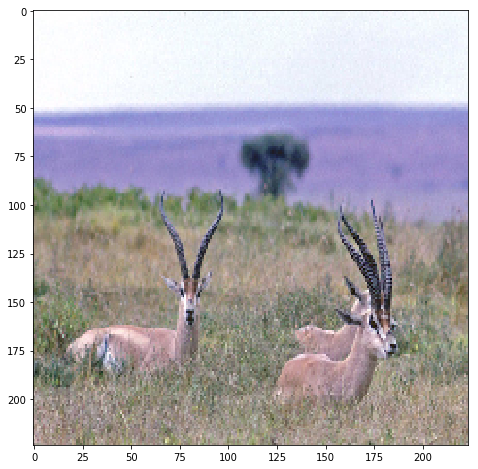

In [11]:
plt.imshow(image_array[123])

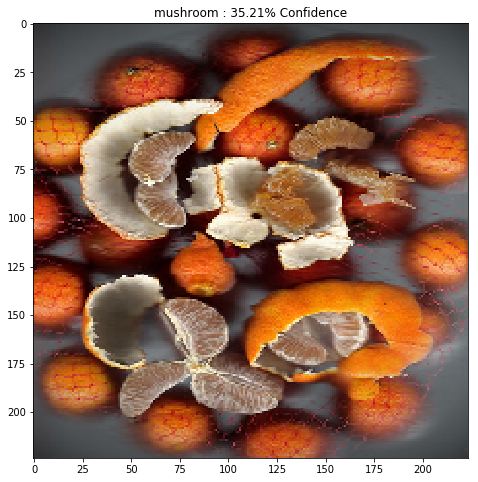

In [12]:
def image_confidence(i):
  imagen = image_array[i]
  dim_imagen = tf.expand_dims(imagen, 0)

  image_probs = pretrained_model.predict(dim_imagen)
  plt.figure()
  plt.imshow(imagen)
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
  plt.show()

image_confidence(199)

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  input_image = tf.expand_dims(input_image, 0)
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


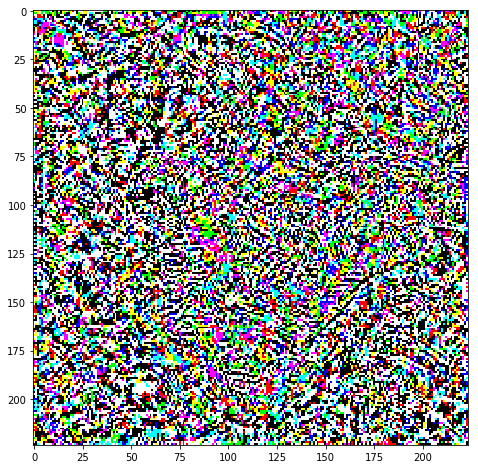

In [14]:
perturbations_for_images = list()


for image in image_array:
  dim_imagen = tf.expand_dims(image, 0)
  image_probs = pretrained_model.predict(dim_imagen)
  perturbations = create_adversarial_pattern(image, image_probs)
  perturbations = tf.squeeze(perturbations)
  perturbations_for_images.append(perturbations)

plt.imshow(perturbations_for_images[0])

In [0]:
def display_images(image, description):
  image = tf.expand_dims(image,0)
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()


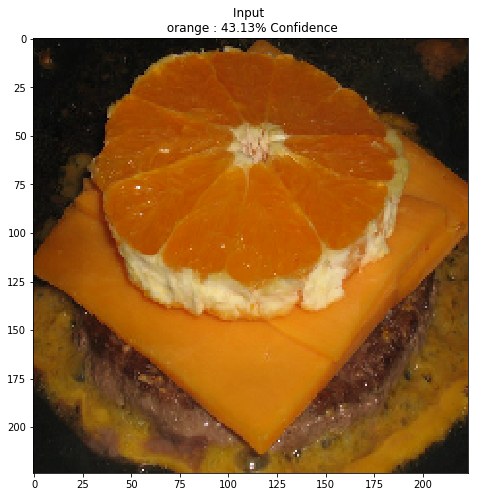

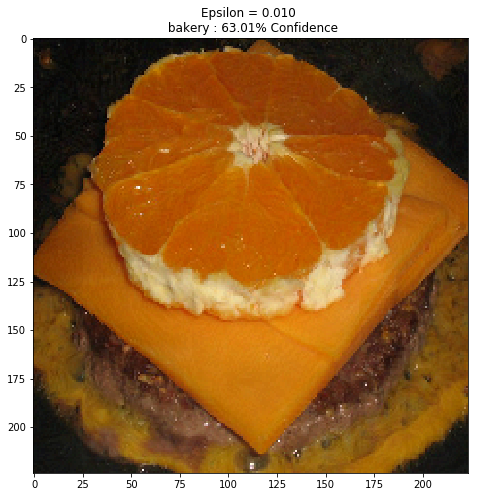

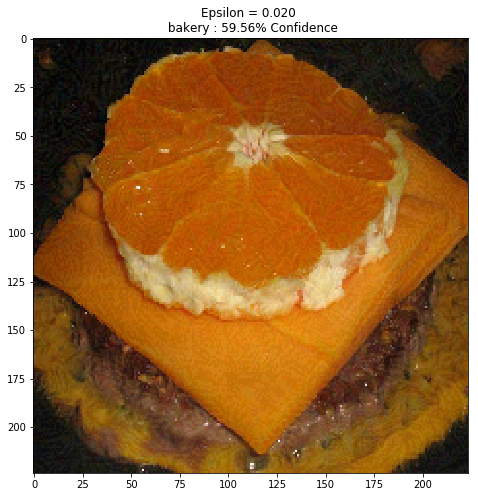

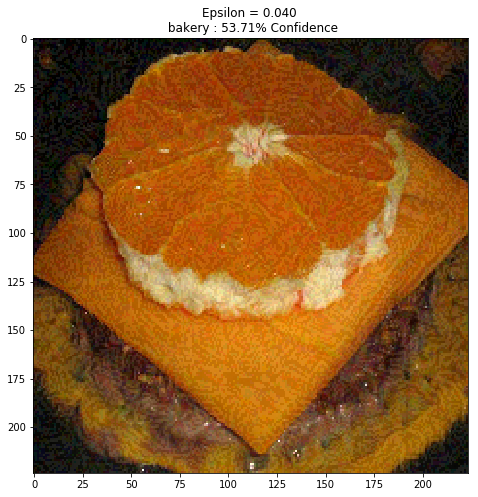

In [45]:
epsilons = [0, 0.01, 0.02, 0.04]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
n = 198

for i, eps in enumerate(epsilons):
  adv_x = image_array[n] + eps*perturbations_for_images[n]
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])


In [35]:
clases = ['snorkel','goldfish','swan','koala','jellyfish','Lhasa','gazelle','missile','mushroom','orange']

number = 0
etiquetas_reales = list()
for i in range(200):
  etiquetas_reales.append(clases[number])
  if i%20 == 19:
    number += 1

labelsOriginales = list()
for n in range(len(image_array)):
  original = tf.expand_dims(image_array[n],0)
  _, label, confidence = get_imagenet_label(pretrained_model.predict(original))
  labelsOriginales.append(label)

print(etiquetas_reales)
print(labelsOriginales)

['snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'swan', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jellyfish', 'jel

In [36]:
predicciones_malas = 0

for i in range(200):
  if labelsOriginales[i] != etiquetas_reales[i]:
    predicciones_malas += 1

print(predicciones_malas)

64


In [0]:
adversarial_examples = list()
eps = 0.04

for n in range(len(image_array)):
  adv_x = image_array[n] + eps*perturbations_for_images[n]
  adversarial_examples.append(adv_x)

In [46]:
wrong = 0
for n in range(len(image_array)):
  if labelsOriginales[n] != etiquetas_reales[n]:
     continue
  else:
    adv_x_example = tf.expand_dims(adversarial_examples[n],0)
    _, label_adv, confidence_adv = get_imagenet_label(pretrained_model.predict(adv_x_example))
    if(labelsOriginales[n] != label_adv):
      wrong += 1

print(wrong)

82


In [44]:
misclassification_rate = wrong/(200-predicciones_malas)
print(misclassification_rate)

0.6029411764705882


# Imagenes de prueba

In [0]:
%cd /content/drive/My drive

image1 = load_img('n0044_1.jpg')

image2 = load_img('n0209_1.jpg')

new_data = list()
new_data.append(image1)
new_data.append(image2)

new_image_array = list()
for elem in new_data:
  new_image_data = preprocess(img_to_array(elem))
  new_image_array.append(new_image_data)



In [0]:
new_per = list()

for image in new_image_array:
  perturbations = create_adversarial_pattern(image, image_probs)
  perturbations = tf.squeeze(perturbations)
  new_per.append(perturbations)

plt.imshow(new_per[0])

In [0]:
epsilons = [0, 0.01, 0.04]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = new_image_array[0] - eps*new_per[0]
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])